<a href="https://colab.research.google.com/github/marcociav/smile-app/blob/master/model-creation/model_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smile App - Model Creation

## Imports

### Packages

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers

from utils import normalize_img
from model import CycleGan, get_resnet_generator, get_discriminator

In [2]:
# check if everything is properly configured
print(f"GPU(s): {tf.config.list_physical_devices('GPU')}")
print(f"tensorflow version: {tf.__version__}")

GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tensorflow version: 2.7.0


### Images

In [3]:
smile_path = 'data/transformed/smile'
non_smile_path = 'data/transformed/non_smile'

### Set constants

In [4]:
# buffer_size = 256
epochs = 100
batch_size = 8
w, h = 64, 64  # known by previously analizing images


## Create Image Datasets

### Train Test Split

In [5]:
smile_ds = image_dataset_from_directory(
    smile_path,
    labels=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(w, h),
    seed=42
)

non_smile_ds = image_dataset_from_directory(
    non_smile_path,
    labels=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(w, h),
    seed=42
)

Found 600 files belonging to 1 classes.
Found 603 files belonging to 1 classes.


In [6]:
smile_ds = smile_ds.map(normalize_img)
non_smile_ds = non_smile_ds.map(normalize_img)

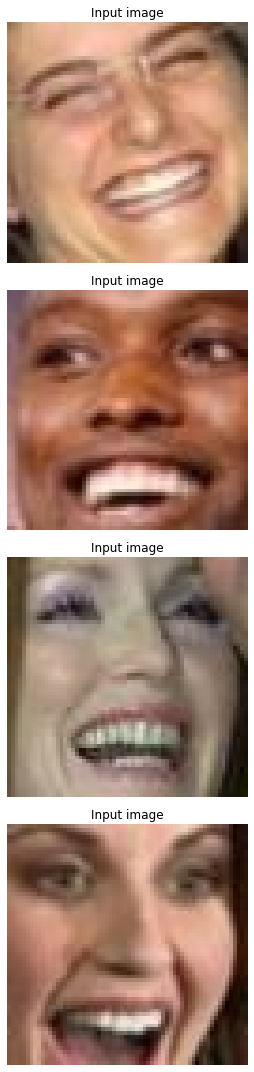

In [7]:
_, ax = plt.subplots(4, 1, figsize=(10, 15))
for i, img in enumerate(smile_ds.take(4)):
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i].imshow(img)
    ax[i].set_title("Input image")
    ax[i].set_title("Input image")
    ax[i].axis("off")

plt.tight_layout()
plt.show()

## Train CycleGAN

In [8]:
# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

In [9]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
# plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath
)

# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
cycle_gan_model.fit(
    tf.data.Dataset.zip((non_smile_ds, smile_ds)),
    epochs=epochs,
    # callbacks=[model_checkpoint_callback],  # add plotter if necessary
)


Epoch 1/100
75/75 [==============================] - 75s 359ms/step - G_loss: 4.3485 - F_loss: 4.3698 - D_X_loss: 0.2255 - D_Y_loss: 0.2322
Epoch 2/100
75/75 [==============================] - 29s 380ms/step - G_loss: 3.2898 - F_loss: 3.3326 - D_X_loss: 0.2027 - D_Y_loss: 0.1641
Epoch 3/100
75/75 [==============================] - 33s 433ms/step - G_loss: 3.2704 - F_loss: 3.3583 - D_X_loss: 0.1585 - D_Y_loss: 0.1744
Epoch 4/100
75/75 [==============================] - 35s 466ms/step - G_loss: 3.0204 - F_loss: 3.3123 - D_X_loss: 0.1507 - D_Y_loss: 0.2344
Epoch 5/100
75/75 [==============================] - 34s 452ms/step - G_loss: 3.0091 - F_loss: 3.2906 - D_X_loss: 0.1642 - D_Y_loss: 0.1975
Epoch 6/100
75/75 [==============================] - 34s 454ms/step - G_loss: 3.0563 - F_loss: 3.2658 - D_X_loss: 0.1552 - D_Y_loss: 0.1866
Epoch 7/100
75/75 [==============================] - 34s 452ms/step - G_loss: 3.0385 - F_loss: 3.1776 - D_X_loss: 0.1680 - D_Y_loss: 0.1737
Epoch 8/100
75/75 [=

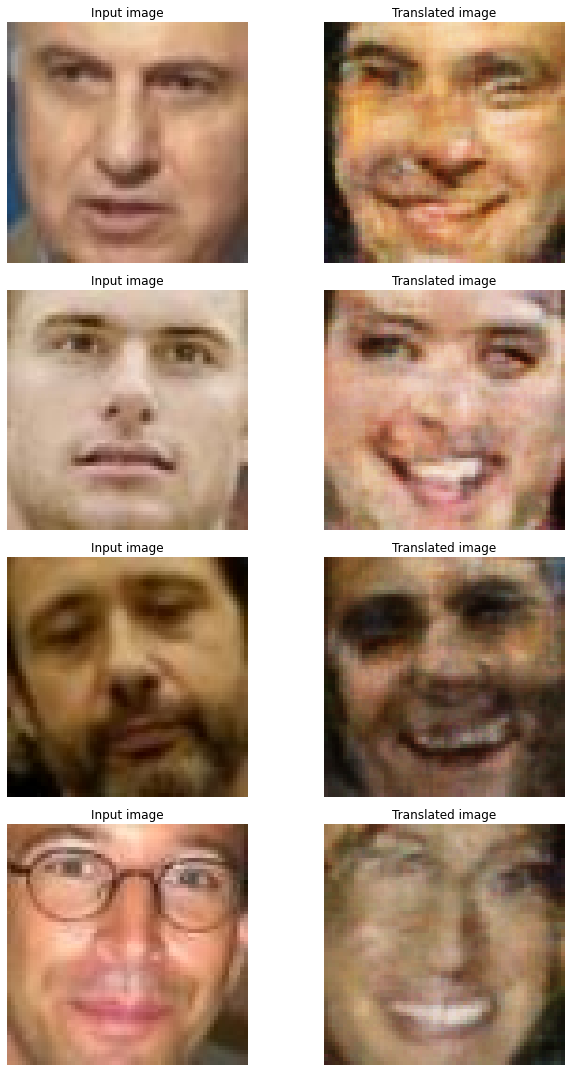

In [10]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(non_smile_ds.take(4)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    # prediction = keras.preprocessing.image.array_to_img(prediction)
    # prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()

In [ ]:
# The plan is to train a CycleGAN where:
# 1. The Generator1 (G1) tries to generate a smile image starting from a non smile
# 2. The Discriminator1 (D1) tries to tell if smile is really a smile
# 3. The Generator2 (G2) tries to generate a non smile image starting from the smile generated by G1
# 4. The Discriminator2 (D2) tries to tell if non smile is really a non smile